## Set-up environment

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 311 kB 9.7 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 6.5 MB 27.6 MB/s 
     |████████████████████████████████| 895 kB 68.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.7 MB/s 
     |████████████████████████████████| 134 kB 72.1 MB/s 
     |████████████████████████████████| 212 kB 66.5 MB/s 
     |████████████████████████████████| 144 kB 67.9 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 66.3 MB/s 


## Load model and feature extractor

In [ ]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation
import torch

model_name = "microsoft/beit-base-finetuned-ade-640-640"
feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, do_center_crop=False)
model = BeitForSemanticSegmentation.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading:   0%|          | 0.00/6.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/858M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


BeitForSemanticSegmentation(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (interm

## Prepare image

Downloading:   0%|          | 0.00/2.79k [00:00<?, ?B/s]

No config specified, defaulting to: fixtures_ade20k/image


  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

Dataset fixtures_ade20k downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___fixtures_ade20k/image/1.9.0/dbb69c3ff2da9a2dcc2de41e8d7ab6543402914292e3d29a4f9701bef817e7db. Subsequent calls will reuse this data.


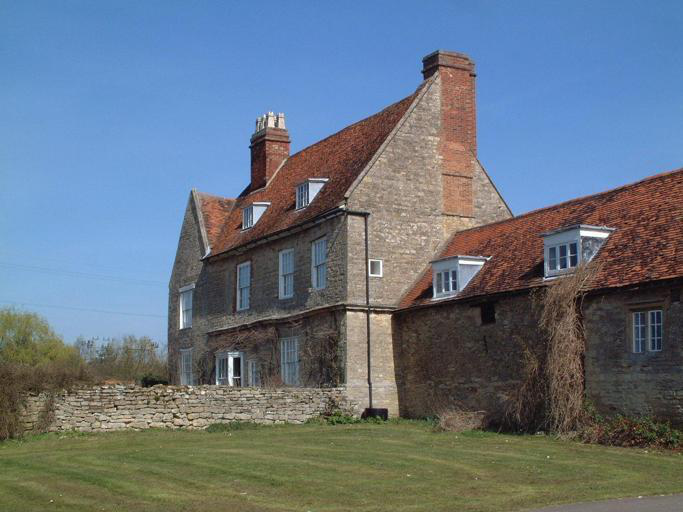

In [ ]:
from datasets import load_dataset
from PIL import Image

# load image + ground truth map
ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test")
image = Image.open(ds[0]["file"])
segmentation_map = Image.open(ds[1]["file"])
image

In [ ]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values.to(device)

## Forward pass

In [ ]:
outputs = model(pixel_values)
logits = outputs.logits

In [ ]:
logits[0, :3, :3, :3]

tensor([[[-4.9225, -2.3954, -3.0522],
         [-2.8822, -1.0046, -1.7561],
         [-2.9548, -1.3228, -2.1347]],

        [[-5.8168, -3.4129, -4.0777],
         [-3.8651, -2.2214, -3.0277],
         [-3.8356, -2.4643, -3.3535]],

        [[-0.0078,  3.9952,  4.0754],
         [ 2.9856,  4.6944,  5.0035],
         [ 3.2413,  4.7813,  4.9969]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
!pip show torch

Name: torch
Version: 1.10.0+cu111
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


## Visualize

In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

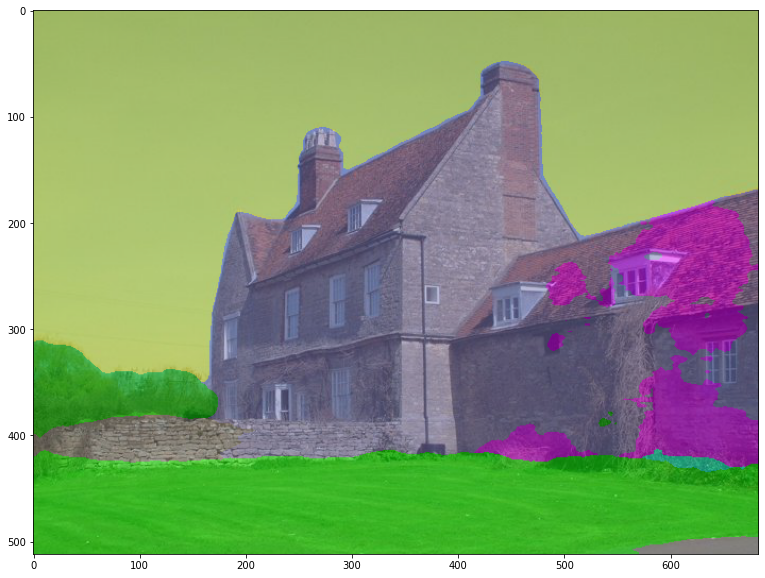

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(outputs.logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = logits.argmax(dim=1)[0].cpu()
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth:

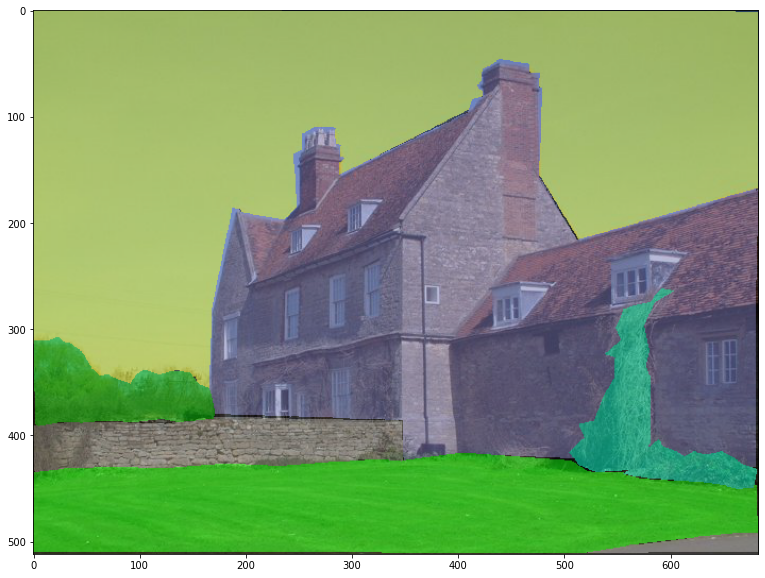

In [ ]:
import numpy as np

ground_truth_seg = np.array(segmentation_map) # 2D ground truth segmentation map
ground_truth_color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    ground_truth_color_seg[ground_truth_seg - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = ground_truth_color_seg[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()